<a href="https://colab.research.google.com/github/MrckHckr/artemis2-go-tests/blob/main/%20notebooks/02_orion_life_support.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Obiettivo

*   Monitorare i sistemi di supporto vitale (Life Support Systems, LSS) durante missione Artemis 2
*   Analizzare Ossigeno, CO2, temperatura, umidità, Consumo risorse (ossigeno, acqua), Anomalie sensori
*   Probabilità di failure dei componenti critici






In [3]:
# Import librerie
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import weibull_min
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

np.random.seed(42)


In [5]:
# Simulazione dati sensori LSS
# Tempo simulato (7 giorni, step 30 minuti)
t = np.arange(0, 7*24*3600, 1800)  # 30 minuti
len(t)  # 336 punti

# Simulazione sensori
oxygen = np.random.normal(21, 0.5, len(t))
co2 = np.random.normal(0.04, 0.01, len(t))
temperature = np.random.normal(22, 1, len(t))
humidity = np.random.normal(50, 5, len(t))

# Introduciamo anomalie simulate
oxygen[50] -= 3
co2[120] += 0.15
temperature[200] += 5
humidity[300] -= 15

# DataFrame sensori LSS
df_lss = pd.DataFrame({
    "time_h": t/3600,
    "oxygen": oxygen,
    "co2": co2,
    "temperature": temperature,
    "humidity": humidity
})

df_lss.head()



,time_h,oxygen,co2,temperature,humidity
0,0.0,20.828656,0.050496,22.949554,52.018650
1,0.5,20.814280,0.034648,20.515102,49.879022
2,1.0,20.296244,0.053174,19.446079,45.481491
3,1.5,20.611092,0.041976,22.934320,51.621796
4,2.0,20.444712,0.060753,20.633121,44.104801


In [6]:
# Anomaly Detection su LSS
# Standardizzazione dei dati
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_lss[["oxygen","co2","temperature","humidity"]])

# Isolation Forest
model = IsolationForest(contamination=0.01, random_state=42)
df_lss["anomaly"] = model.fit_predict(X_scaled)

# -1 = anomalia, 1 = normale
df_lss.head()


,time_h,oxygen,co2,temperature,humidity,anomaly
0,0.0,20.828656,0.050496,22.949554,52.018650,1
1,0.5,20.814280,0.034648,20.515102,49.879022,1
2,1.0,20.296244,0.053174,19.446079,45.481491,1
3,1.5,20.611092,0.041976,22.934320,51.621796,1
4,2.0,20.444712,0.060753,20.633121,44.104801,1


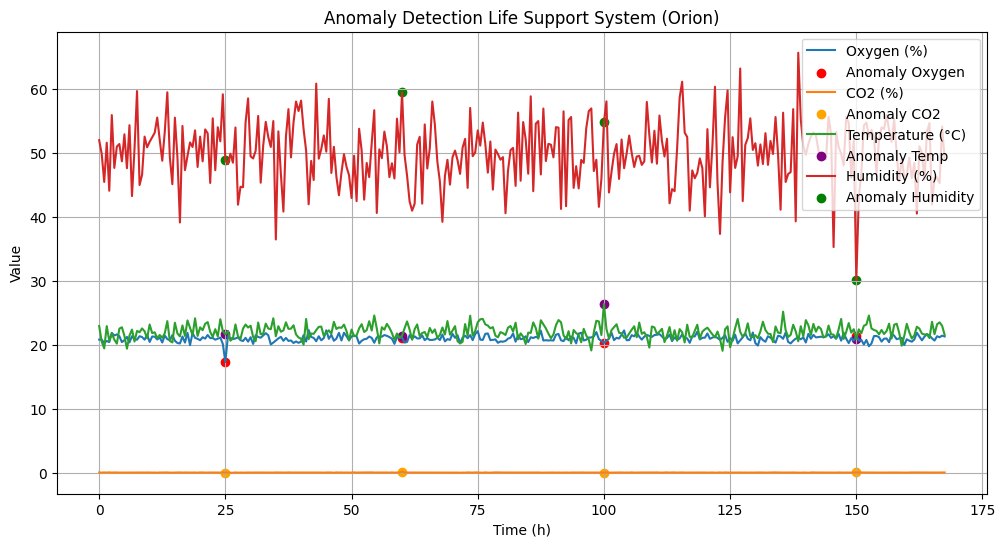

In [7]:
# Visualizzazione anomalie
plt.figure(figsize=(12,6))

# Ossigeno
plt.plot(df_lss["time_h"], df_lss["oxygen"], label="Oxygen (%)")
plt.scatter(df_lss[df_lss["anomaly"]==-1]["time_h"],
            df_lss[df_lss["anomaly"]==-1]["oxygen"],
            color="red", label="Anomaly Oxygen")

# CO2
plt.plot(df_lss["time_h"], df_lss["co2"], label="CO2 (%)")
plt.scatter(df_lss[df_lss["anomaly"]==-1]["time_h"],
            df_lss[df_lss["anomaly"]==-1]["co2"],
            color="orange", label="Anomaly CO2")

# Temperatura
plt.plot(df_lss["time_h"], df_lss["temperature"], label="Temperature (°C)")
plt.scatter(df_lss[df_lss["anomaly"]==-1]["time_h"],
            df_lss[df_lss["anomaly"]==-1]["temperature"],
            color="purple", label="Anomaly Temp")

# Umidità
plt.plot(df_lss["time_h"], df_lss["humidity"], label="Humidity (%)")
plt.scatter(df_lss[df_lss["anomaly"]==-1]["time_h"],
            df_lss[df_lss["anomaly"]==-1]["humidity"],
            color="green", label="Anomaly Humidity")

plt.xlabel("Time (h)")
plt.ylabel("Value")
plt.title("Anomaly Detection Life Support System (Orion)")
plt.legend()
plt.grid(True)
plt.show()


In [8]:
# Decisione GO / NO-GO LSS
# Massimo consentito di anomalie
max_allowed_anomalies = 5
anomalies_detected = (df_lss["anomaly"]==-1).sum()

# Semaforo
if anomalies_detected <= max_allowed_anomalies:
    print("✅ GO: Life Support System nei limiti")
else:
    print("❌ NO-GO: Anomalie critiche LSS, revisione necessaria")

print(f"Anomalie rilevate: {anomalies_detected} (max consentite: {max_allowed_anomalies})")


✅ GO: Life Support System nei limiti
Anomalie rilevate: 4 (max consentite: 5)


In [9]:
# Possibile Estensione: Survival Analysis Componenti Critici
# Simulazione tempi di failure dei componenti LSS (es. CO2 scrubber)
n_components = 50
shape = 2.5
scale = 2000  # ore
failure_times = weibull_min.rvs(shape, scale=scale, size=n_components)

df_failure = pd.DataFrame({"component_id": range(n_components),
                           "time_to_failure_h": failure_times})

# Probabilità di failure entro la missione (168h)
p_failure = (df_failure["time_to_failure_h"] <= 168).mean()
print(f"P(failure componenti LSS entro missione: {p_failure:.4f})")


P(failure componenti LSS entro missione: 0.0200)
